# 𝕆𝕦𝕥 𝕠𝕗 𝕕𝕚𝕤𝕥𝕣𝕚𝕓𝕦𝕥𝕚𝕠𝕟

* VQVAE

Source:
* https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb

In [1]:
import os


import torch
import torch.nn
import torch.optim as optim
from torch.autograd import Variable


import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import numpy as np

import random
import math
import time

import skimage.io

# vae
import argparse
import pickle

import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import lmdb
from tqdm import tqdm

import sys
sys.path.insert(0, "helper")
from helper.dataset.vqvae import ImageFileDataset, CodeRow
from helper.model.vqvae import VQVAE
import pathlib

import torchvision

# not sure i am using this ... maybe it's automatically??
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



In [2]:
p = pathlib.PurePath('/src/goo/scripts/main.py')
p.parent.parent.name         

'goo'

  0%|                                                                                          | 0/312 [00:00<?, ?it/s]

img: b+f x c x w x h torch.Size([15, 3, 256, 256])
before shape top torch.Size([15, 32, 32])
## shape reshaped top torch.Size([15, 1, 64, 64])
## shape reshaped bot torch.Size([15, 1, 64, 64])
vae: b+f x c x w x h torch.Size([15, 2, 64, 64])
vae: b x f x c x w x h torch.Size([3, 5, 2, 64, 64])
vae: b x c x f x w x h torch.Size([3, 2, 5, 64, 64])


inserted: 15:   0%|▏                                                                 | 1/312 [00:17<1:31:47, 17.71s/it]

## shape id top torch.Size([15, 1, 64, 64])


inserted: 15:   0%|▏                                                                 | 1/312 [00:18<1:36:09, 18.55s/it]


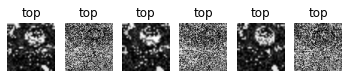

In [16]:
def extract(lmdb_env, loader, model, device, plot=False):
    index = 0
    
    with lmdb_env.begin(write=True) as txn:
        pbar = tqdm(loader)

        # for each batch
        for img, _, filename in pbar:
            
            
            if index > 8:
                break
            
            img = img.to(device)

            # this is just for mimicing the dataloader??
            img = img.view(15,3,256,256)
            print("img: b+f x c x w x h", img.shape)
            
            _, _, _, id_t, id_b = model.encode(img)
            
            print("before shape top", id_t.shape)
            resize = torchvision.transforms.Resize((64,64))
            id_t = resize(id_t)
            id_t = id_t.unsqueeze(1)
            id_b = id_b.unsqueeze(1)
            
            print("## shape reshaped top", id_t.shape)
            print("## shape reshaped bot", id_b.shape)
            
            vit_batch = torch.cat([id_t, id_b], dim=1) 
            print("vae: b+f x c x w x h", vit_batch.shape)
            
            vit_batch = vit_batch.view(3,5,2,64,64)
            print("vae: b x f x c x w x h", vit_batch.shape)
            
            vit_batch = vit_batch.permute(0, 2, 1, 3, 4)
            print("vae: b x c x f x w x h", vit_batch.shape)
            
            vit_batch_np = vit_batch.detach().cpu().numpy()

            fig, axs = plt.subplots(1, 6)
            
            i = 0
            axs[i].set_title("top")
            axs[i].imshow(vit_batch_np[0, 0, 0], cmap="gray")
            axs[i].axis('off')
            i+=1
            
            axs[i].set_title("top")
            axs[i].imshow(vit_batch_np[0, 1, 0], cmap="gray")
            axs[i].axis('off')
            i+=1
            
            axs[i].set_title("top")
            axs[i].imshow(vit_batch_np[0, 0, 1], cmap="gray")
            axs[i].axis('off')
            i+=1
            
            axs[i].set_title("top")
            axs[i].imshow(vit_batch_np[0, 1, 1], cmap="gray")
            axs[i].axis('off')
            i+=1
            
            axs[i].set_title("top")
            axs[i].imshow(vit_batch_np[0, 0, 2], cmap="gray")
            axs[i].axis('off')
            i+=1
            
            axs[i].set_title("top")
            axs[i].imshow(vit_batch_np[0, 1, 2], cmap="gray")
            axs[i].axis('off')
            i+=1
            


            

            # for each image
            for fname, top, bottom in zip(filename, id_t, id_b):
                
               
                
                base_name = os.path.basename(fname)
                
                index += 1
                pbar.set_description(f'inserted: {index}')
                
                
                
                if plot:
                    top_np = top.detach().cpu().numpy()
                    bottom_np = bottom.detach().cpu().numpy()
                
                    print(top_np.shape)
                    print(bottom_np.shape)
                    print(fname)

                    axs[3].set_title("top")
                    axs[3].imshow(top, cmap="gray")
                    axs[3].axis('off')

                    axs[4].set_title("bottom")
                    axs[4].imshow(bottom, cmap="gray")
                    axs[4].axis('off')
                
            print("## shape id top", id_t.shape)
        
        txn.put('length'.encode('utf-8'), str(index).encode('utf-8'))


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    #parser.add_argument('--size', type=int, default=256)
    #parser.add_argument('--ckpt', type=str)
    #parser.add_argument('--name', type=str)
    #parser.add_argument('path', type=str)

    #args = parser.parse_args()
    
    
    size = 256
    ckpt = r"C:/Users/Prinzessin/projects/cataract/vq-vae-2-pytorch-master/checkpoint/vqvae_500.pt"
    name = "gouda"
    path = r"C:/Users/Prinzessin/projects/image_data/cataract_CaDISv2/data"
    

    device = 'cuda:0'

    transform = transforms.Compose(
        [
            transforms.Resize(size),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )

    dataset = ImageFileDataset(path, transform=transform)
    loader = DataLoader(dataset, batch_size=15, shuffle=False, num_workers=4)

    # Choose whatever GPU device number you want
    # model.load_state_dict(torch.load(PATH, map_location="cuda:0"))
    
    model = VQVAE()
    model.load_state_dict(torch.load(ckpt, map_location="cuda:0"))
    model = model.to(device)
    model.eval()

    map_size = 100 * 256 * 256 * 256 # 100 * 1024 * 1024 * 1024

    env = lmdb.open(name, map_size=map_size)

    extract(env, loader, model, device)


In [4]:
49152 / 2 / 3 / 2 / 64

64.0

In [10]:
2949120 / 15/256/256/3

1.0

In [5]:
def extract(lmdb_env, loader, model, device, plot=False):
    index = 0
    
    with lmdb_env.begin(write=True) as txn:
        pbar = tqdm(loader)

        # for each batch
        for img, _, filename in pbar:
            
            
            if index > 8:
                break
            
            img = img.to(device)

            if True:
                _, _, _, id_t, id_b = model.encode(img)
            else:
                a, b, c, id_t, id_b = model.encode(img)
                a = a.detach().cpu().numpy()
                b = b.detach().cpu().numpy()
                c = c.detach().cpu().numpy()
                img = img.detach().cpu().numpy()

                print("a", a.shape)
                print("b", b.shape)
                print("c", c)
                print("t", id_t.shape)
                print("b", id_b.shape)
            
                if plot:
                    fig, axs = plt.subplots(1, 5)

                    axs[0].set_title("original")
                    axs[0].imshow(img[0].transpose(1,2,0), cmap="gray")
                    axs[0].axis('off')

                    axs[1].imshow(a[0][0], cmap="gray")
                    axs[1].set_title("1/64")
                    axs[1].axis('off')

                    axs[2].imshow(b[0][0], cmap="gray")
                    axs[2].set_title("1/64")
                    axs[2].axis('off')
            
            

            for fname, top, bottom in zip(filename, id_t, id_b):
                row = CodeRow(top=top, bottom=bottom, filename=fname)
                
                base_name = os.path.basename(fname)
                
                top_np = top.detach().cpu().numpy()
                bottom_np = bottom.detach().cpu().numpy()
                
                video_dir = os.path.join("results/gouda/", base_name.split("_")[0])

                if not os.path.exists(video_dir):
                    os.makedirs(video_dir)
                fname = os.path.join(video_dir, base_name)
                skimage.io.imsave(fname=fname ,arr=top_np)
                
                if plot:
                    print(top_np.shape)
                    print(bottom_np.shape)
                    print(fname)

                    axs[3].set_title("top")
                    axs[3].imshow(top, cmap="gray")
                    axs[3].axis('off')

                    axs[4].set_title("bottom")
                    axs[4].imshow(bottom, cmap="gray")
                    axs[4].axis('off')

                txn.put(str(index).encode('utf-8'), pickle.dumps(row))
                index += 1
                pbar.set_description(f'inserted: {index}')
                
                print("## shape top", top.shape)
                resize = torchvision.transforms.Resize(64)
                top = resize(top)
                print("## shape reshaped top", top.shape)
                
            print("## shape id top", id_t.shape)
        
        txn.put('length'.encode('utf-8'), str(index).encode('utf-8'))


if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    #parser.add_argument('--size', type=int, default=256)
    #parser.add_argument('--ckpt', type=str)
    #parser.add_argument('--name', type=str)
    #parser.add_argument('path', type=str)

    #args = parser.parse_args()
    
    
    size = 256
    ckpt = r"C:/Users/Prinzessin/projects/cataract/vq-vae-2-pytorch-master/checkpoint/vqvae_500.pt"
    name = "gouda"
    path = r"C:/Users/Prinzessin/projects/image_data/cataract_CaDISv2/data"
    

    device = 'cuda:0'

    transform = transforms.Compose(
        [
            transforms.Resize(size),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
        ]
    )

    dataset = ImageFileDataset(path, transform=transform)
    loader = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4)

    # Choose whatever GPU device number you want
    # model.load_state_dict(torch.load(PATH, map_location="cuda:0"))
    
    model = VQVAE()
    model.load_state_dict(torch.load(ckpt, map_location="cuda:0"))
    model = model.to(device)
    model.eval()

    map_size = 100 * 256 * 256 * 256 # 100 * 1024 * 1024 * 1024

    env = lmdb.open(name, map_size=map_size)

    extract(env, loader, model, device)


  0%|                                                                                         | 0/1168 [00:00<?, ?it/s]C:\Users\Prinzessin\AppData\Local\Temp\ipykernel_24980\4180643369.py:61: UserWarning: results/gouda/Video1\Video1_frame000090.png is a low contrast image
  skimage.io.imsave(fname=fname ,arr=top_np)
Lossy conversion from int64 to uint8. Range [11, 419]. Convert image to uint8 prior to saving to suppress this warning.
inserted: 1:   0%|                                                                            | 0/1168 [00:17<?, ?it/s]

## shape top torch.Size([32, 32])


inserted: 1:   0%|                                                                            | 0/1168 [00:18<?, ?it/s]


ValueError: Input and output must have the same number of spatial dimensions, but got input with spatial dimensions of [32] and output size of [64, 64]. Please provide input tensor in (N, C, d1, d2, ...,dK) format and output size in (o1, o2, ...,oK) format.

# Prepare Data

In [ ]:
spacy_vae_features = spacy.load('de_core_news_sm')
spacy_i_dont_know = spacy.load('en_core_web_sm')

def tokenize_vae_features(text):
    """
    Tokenizes vae autoencoders from a numpy array
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_i_dont_know(text):
    """
    Class labels???
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]


SRC = Field(tokenize = tokenize_vae_features, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_i_dont_know, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)



# Dataset

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)


train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)



# Model
* https://pytorch.org/text/main/tutorials/t5_demo.html#generate-sentiment-classifications

In [ ]:
batch = next(iter(imdb_dataloader))
input_text = batch["text"]
target = batch["label"]
beam_size = 1

model_input = transform(input_text)
model_output = sequence_generator.generate(model_input, eos_idx=eos_idx, num_beams=beam_size)
output_text = transform.decode(model_output.tolist())

for i in range(imdb_batch_size):
    print(f"Example {i+1}:\n")
    print(f"input_text: {input_text[i]}\n")
    print(f"prediction: {output_text[i]}\n")
    print(f"target: {target[i]}\n\n")

In [ ]:
# Example - Pretrained large xlmr encoder attached to un-initialized classification head

import torch, torchtext
from torchtext.models import RobertaClassificationHead
from torchtext.functional import to_tensor
xlmr_large = torchtext.models.XLMR_LARGE_ENCODER
classifier_head = torchtext.models.RobertaClassificationHead(num_classes=2, input_dim = 1024)
model = xlmr_large.get_model(head=classifier_head)
transform = xlmr_large.transform()
input_batch = ["Hello world", "How are you!"]
model_input = to_tensor(transform(input_batch), padding_value=1)
output = model(model_input)
output.shape



In [ ]:
from torchtext.models import RobertaEncoderConf, RobertaBundle, RobertaClassificationHead
model_weights_path = "https://download.pytorch.org/models/text/xlmr.base.encoder.pt"
encoder_conf = RobertaEncoderConf(vocab_size=250002)
classifier_head = RobertaClassificationHead(num_classes=18, input_dim=768)
model = RobertaBundle.build_model(encoder_conf=encoder_conf, head=classifier_head, checkpoint=model_weights_path)

In [ ]:

class OODModel(torch.nn.Module):
    # =============================================================================
    # use this
    # encoder backbone (shufflenet_v2_x1_0) + projection head (MLP)
    # output size of MLP: 128 
    # this feature vector is then used for the SupConLoss

    # Replace model head:
    # https://discuss.pytorch.org/t/how-to-replace-a-models-head/109002/2
    # shuffle net: (fc): Linear(in_features=1024, out_features=1000, bias=True)

    # this function is used to train a DecentBlock with the SupConLoss
    # =============================================================================
    
    def __init__(self, out_classes=20):
        super(OODModel, self).__init__()
        
        self.out_classes = out_classes
        
        # encoder
        try:
            shufflenet = shufflenet_v2_x1_0(weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1)
        except: 
            shufflenet = shufflenet_v2_x1_0(pretrained=True)
                    
        # size of encoder output
        encoder_out = shufflenet.fc.in_features
            
        # placeholder identity operator 
        shufflenet.fc = torch.nn.Identity()
                
        # encoder without fully connected classification head (linear layer)
        self.encoder = shufflenet
        
        # maybe we need concatenation or view change here ... 1x1 conv??
        
        # MLP head
        self.mlp_head = torch.nn.Sequential(
            torch.nn.Linear(encoder_out, encoder_out),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(encoder_out, 128)
        )
        
        self.classification = torch.nn.Sequential(
            torch.nn.Linear(128, self.out_classes)
        )
        

    def forward(self, x):
        x = self.encoder(x)
        x = self.mlp_head(x)
        block_output = torch.nn.functional.normalize(x, dim=1)
        
        
        
        return block_output